In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
import cv2

import h5py

In [ ]:
batch_size1=32

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
y_train_generator = train_datagen.flow_from_directory(
        '/content/drive/My Drive/Coloring/Datasets/train_images1',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size1,
        class_mode=None, color_mode='rgb',seed=61) 

Found 8294 images belonging to 1 classes.


In [ ]:
x_train_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Coloring/Datasets/bw_train_images1',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size1,
        class_mode=None, color_mode='grayscale',seed=61) 

Found 8294 images belonging to 1 classes.


In [ ]:
x_val_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Coloring/Datasets/bw_val_images1',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size1,
        class_mode=None, color_mode='grayscale',seed=61) 

Found 1000 images belonging to 1 classes.


In [ ]:
y_val_generator = train_datagen.flow_from_directory('/content/drive/My Drive/Coloring/Datasets/val_images1',  # this is the target directory
        target_size=(224, 224),  # all images will be resized to 150x150
        batch_size=batch_size1,
        class_mode=None, color_mode='rgb',seed=61) 

Found 1000 images belonging to 1 classes.


In [ ]:
#create a model

input1=keras.layers.Input(shape=(224,224,1))

h1=keras.layers.Conv2D(32,(3,3),padding='same')(input1)
#h1=keras.layers.Conv2D(32,(3,3))(h1)
h1=keras.layers.BatchNormalization()(h1)
h1=keras.layers.LeakyReLU(alpha=0.2)(h1)
h1=keras.layers.MaxPooling2D((2,2),2)(h1)


h2=keras.layers.Conv2D(64,(3,3),padding='same')(h1)
#h2=keras.layers.Conv2D(64,(3,3))(h2)
h2=keras.layers.BatchNormalization()(h2)
h2=keras.layers.LeakyReLU(alpha=0.2)(h2)
h2=keras.layers.MaxPooling2D((2,2),2)(h2)

h3=keras.layers.Conv2D(128,(3,3),padding='same')(h2)
#h3=keras.layers.Conv2D(128,(3,3))(h3)
h3=keras.layers.BatchNormalization()(h3)
h3=keras.layers.LeakyReLU(alpha=0.2)(h3)
h3=keras.layers.MaxPooling2D((2,2),2)(h3)

##decoder

h4=keras.layers.Conv2D(128,(3,3),padding='same')(h3)
#h4=keras.layers.Conv2D(256,(3,3))(h4)
h4=keras.layers.BatchNormalization()(h4)
h4=keras.layers.LeakyReLU(alpha=0.2)(h4)
h4=keras.layers.UpSampling2D((2,2))(h4)

#h4=keras.layers.Conv2D(256,(3,3),padding='valid')(h4)

#h5=keras.layers.UpSampling2D()(h4)
h5=keras.layers.Conv2D(64,(3,3),padding='same',name='decoder_starts')(h4)
h5=keras.layers.BatchNormalization()(h5)
h5=keras.layers.LeakyReLU(alpha=0.2)(h5)
h5=keras.layers.UpSampling2D((2,2))(h5)

h6=keras.layers.Conv2D(32,(3,3),padding='same')(h5)
h6=keras.layers.BatchNormalization()(h6)
h6=keras.layers.LeakyReLU(alpha=0.2)(h6)
h6=keras.layers.UpSampling2D((2,2))(h6)

h7=keras.layers.Conv2D(3,(3,3),padding='same')(h6)
#h7=keras.layers.BatchNormalization()(h7)
#h7=keras.layers.LeakyReLU(alpha=0.2)(h7)
#h7=keras.layers.UpSampling2D((2,2))(h7)

#h7=keras.layers.Conv2D(3,(3,3),padding='same')(h7)



output=h7

model=keras.Model(inputs=input1, outputs=output)

model.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)     

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, min_delta=1e-4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=10, verbose=1, min_delta=1e-4)
callbacks_list = [early_stop, reduce_lr]

In [ ]:
model.compile(loss='mse',optimizer=keras.optimizers.Adam(lr=0.001))
#history=model.fit_generator(train_generator,epochs=1,callbacks=callbacks_list)

#history=model.fit(train_generator,test_generator,steps_per_epoch=9246//1,epochs=2)

history=model.fit(zip(x_train_generator,y_train_generator),steps_per_epoch=8246//batch_size1,epochs=150,callbacks=callbacks_list,validation_data =zip(x_val_generator,y_val_generator) ,validation_steps=1000//batch_size1)
#history=model.fit(zip(test_generator,train_generator),steps_per_epoch=9246//batch_size1,epochs=600)


Epoch 1/150
257/257 [==============================] - 8097s 32s/step - loss: 0.0390 - val_loss: 0.0483
Epoch 2/150
257/257 [==============================] - 202s 787ms/step - loss: 0.0151 - val_loss: 0.0160
Epoch 3/150
257/257 [==============================] - 173s 674ms/step - loss: 0.0139 - val_loss: 0.0155
Epoch 4/150
257/257 [==============================] - 172s 668ms/step - loss: 0.0136 - val_loss: 0.0165
Epoch 5/150
257/257 [==============================] - 172s 669ms/step - loss: 0.0133 - val_loss: 0.0158
Epoch 6/150
257/257 [==============================] - 172s 668ms/step - loss: 0.0123 - val_loss: 0.0129
Epoch 7/150
257/257 [==============================] - 172s 669ms/step - loss: 0.0126 - val_loss: 0.0134
Epoch 8/150
257/257 [==============================] - 171s 667ms/step - loss: 0.0118 - val_loss: 0.0133
Epoch 9/150
257/257 [==============================] - 169s 659ms/step - loss: 0.0120 - val_loss: 0.0127
Epoch 10/150
257/257 [==============================] - 

In [ ]:
model.save('/content/drive/My Drive/Coloring/Autoencoder_colorizer.h5')

In [3]:
model=tf.keras.models.load_model('/content/drive/My Drive/Coloring/Autoencoder_colorizer.h5')
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 224, 224, 32)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 64)     

(256, 256, 3)


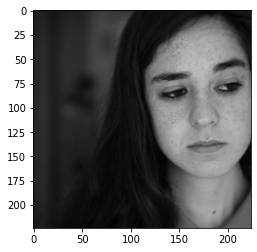

In [12]:
image=mpimg.imread('f1.jpg')
print(image.shape)
image=cv2.resize(image,(224,224))
plt.imshow(image)
bw_image=cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
#plt.imshow(bw_image)

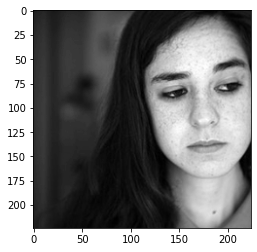

In [13]:
plt.imshow(bw_image,cmap='gray')

In [14]:
bw_image=bw_image/255.0
bw_image=bw_image.reshape(1,224,224,1)


In [15]:
p=model.predict(bw_image)
p.shape

(1, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


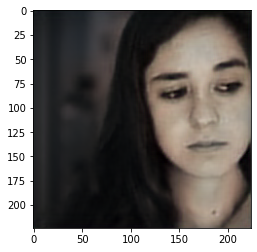

In [16]:
plt.imshow(p[0])